In [6]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from src.model.samadhi import SamadhiModel
from src.train.supervised_trainer import SupervisedSamadhiTrainer

In [7]:
# 1. Config & Model
CONFIG = {
    "dim": 784,
    "n_probes": 10,
    "refine_steps": 15,
    "softmax_temp": 0.2,
    "gate_threshold": -1,
    "stability_coeff": 0.01,
    "entropy_coeff": 0.05,
    "balance_coeff": 0.9,
    "mix_alpha": 0.2,
    "probe_trainable": True,
    "vicara_type": "probe_specific",
    "training_attention_mode": "soft",
    "prediction_attention_mode": "hard",
    "inertia": 0.7,
}

In [8]:
# --- Custom Dataset for (noisy_x, clean_y) pairs ---
class MNISTPairDataset(Dataset):
    """Custom Dataset to provide pairs of (noisy_input, clean_target) along with labels."""

    def __init__(self, mnist_dataset, noise_fn):
        self.mnist_dataset = mnist_dataset
        self.noise_fn = noise_fn

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        clean_img, label = self.mnist_dataset[idx]
        # Flatten clean_img here to match model's expected input dimension
        clean_img_flat = clean_img.view(-1)
        noisy_img_flat = self.noise_fn(clean_img_flat.unsqueeze(0)).squeeze(
            0
        )  # noise_fn expects batch, then squeeze back
        return noisy_img_flat, clean_img_flat, label


def visualize_inference(trainer, dataloader, num_samples=5):
    """Visualizes inference results via both console output and images.

    Also displays a histogram to check for Probe Collapse.

    Args:
        trainer: The trainer instance containing the model.
        dataloader: DataLoader providing the test data.
        num_samples (int): Number of samples to visualize detailed results for. Defaults to 5.
    """
    device = trainer.device

    # --- A. Probe Usage Statistics (Entire Batch or Subset) ---
    print("\nCalculating Probe Usage Statistics...")
    winner_counts = {}
    total_samples = 0

    # Analyze a subset (e.g., up to 200 samples) to be quick
    stats_limit = 200

    trainer.model.eval()
    with torch.no_grad():
        for batch_data in dataloader:
            if total_samples >= stats_limit:
                break

            x_noisy, _, _ = batch_data
            x_noisy = x_noisy.to(device)

            # Vitakka Search to get winner_id
            _, metadata = trainer.model.vitakka_search(x_noisy)

            # Count winners
            winners = metadata["winner_id"]
            if isinstance(winners, torch.Tensor):
                winners = winners.cpu().numpy()

            # For Soft Attention, winner_id is already calculated as argmax in Vitakka
            for w in winners:
                w = int(w)
                winner_counts[w] = winner_counts.get(w, 0) + 1
                total_samples += 1

    print(f"Probe Usage (over {total_samples} samples):")
    sorted_keys = sorted(winner_counts.keys())
    for k in sorted_keys:
        count = winner_counts[k]
        percentage = (count / total_samples) * 100
        print(f"  Probe {k}: {count} ({percentage:.1f}%)")

    # Missing probes check
    all_probes = set(range(trainer.model.config["n_probes"]))
    used_probes = set(winner_counts.keys())
    dead_probes = all_probes - used_probes
    if dead_probes:
        print(f"  Dead Probes (0% usage): {dead_probes}")
    else:
        print("  All probes are active!")

    # --- B. Detailed Visualization (Few Samples) ---

    # 1. Prepare data (only 5 samples) - Get (noisy_x, clean_y, label) from dataloader
    x_noisy_batch, y_clean_batch, labels = next(iter(dataloader))
    x_noisy_batch = x_noisy_batch[:num_samples].to(device)
    y_clean_batch = y_clean_batch[:num_samples].to(device)
    labels = labels[:num_samples]

    # Temporary DataLoader for predict (predict handles x_in = data[i:i+1] internally, so pass TensorDataset with only x_noisy_batch here)
    temp_dataset = torch.utils.data.TensorDataset(x_noisy_batch.cpu())
    temp_loader = DataLoader(temp_dataset, batch_size=num_samples)

    # 2. Execute inference
    results, logs = trainer.predict(temp_loader)

    # ==========================================
    # 3. Display results in text
    # ==========================================
    print(f"\n{'ID':<3} | {'Truth':<5} | {'Pred':<5} | {'Conf':<6} | {'Result'}")
    print("-" * 45)

    for i in range(num_samples):
        gt = labels[i].item()

        if logs[i]:
            p_log = logs[i]["probe_log"]
            pred_lbl = p_log["winner_label"]
            conf = p_log["confidence"]

            print(f"{i:<3} | {gt:<5} | {pred_lbl:<5} | {conf:.2f}   | (Purified)")
        else:
            # Gate Closed
            print(f"{i:<3} | {gt:<5} | {'-':<5} | {'----':<6} | ⬛ Gate Closed")

    print("-" * 45)

    # ==========================================
    # 4. Display results in images (Visualization)
    # ==========================================
    # Layout: Rows 1-3 for images, Row 4 for Histogram
    fig = plt.figure(figsize=(num_samples * 2.5, 12))
    gs = fig.add_gridspec(4, num_samples)

    rows = ["Input (Noisy)", "Output (Samadhi)", "Ground Truth"]
    colors = ["black", "blue", "green"]

    for row_idx, (row_name, color) in enumerate(zip(rows, colors)):
        ax0 = fig.add_subplot(gs[row_idx, 0])
        ax0.set_ylabel(row_name, fontsize=12, fontweight="bold", color=color)
        # Remove ticks from the label axis placeholder if needed, but plotting loop handles it below

    for i in range(num_samples):
        gt = labels[i].item()

        # A. Input
        ax = fig.add_subplot(gs[0, i])
        # Denormalize: [-1, 1] -> [0, 1]
        img_in = (x_noisy_batch[i].view(28, 28).cpu().numpy() + 1) / 2
        ax.imshow(img_in, cmap="gray", vmin=0, vmax=1)
        ax.set_title(f"Label: {gt}")
        ax.axis("off")

        # B. Output
        ax = fig.add_subplot(gs[1, i])
        img_out = (results[i].view(28, 28).numpy() + 1) / 2
        ax.imshow(img_out, cmap="gray", vmin=0, vmax=1)
        ax.axis("off")

        if logs[i]:
            p_log = logs[i]["probe_log"]
        else:
            ax.text(0.5, 0.5, "Gate Closed", ha="center")
            ax.set_title("Ignored")

        # C. Ground Truth (using y_clean_batch)
        ax = fig.add_subplot(gs[2, i])
        img_clean = (y_clean_batch[i].view(28, 28).cpu().numpy() + 1) / 2
        ax.imshow(img_clean, cmap="gray", vmin=0, vmax=1)
        ax.set_title("Original")
        ax.axis("off")

    # --- Histogram Plot ---
    ax_hist = fig.add_subplot(gs[3, :])
    probes = list(range(trainer.model.config["n_probes"]))
    counts = [winner_counts.get(p, 0) for p in probes]

    ax_hist.bar(probes, counts, color="purple", alpha=0.7)
    ax_hist.set_xticks(probes)
    ax_hist.set_xlabel("Probe ID")
    ax_hist.set_ylabel("Count")
    ax_hist.set_title(f"Probe Usage Distribution (n={total_samples})")
    ax_hist.grid(axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


def visualize_probes(model, num_probes=10):
    """Visualizes the learned probes after training.

    Probes are initialized with representative samples and refined during training.

    Args:
        model: The trained Samadhi model.
        num_probes (int): Number of probes to visualize. Defaults to 10.
    """
    print("\nVisualizing Probes (Learned Concepts)...")
    fig, axes = plt.subplots(1, num_probes, figsize=(num_probes * 1.5, 2))

    # Normalize and display probes (for better visualization as images)
    probes = model.probes.detach().cpu()

    for i in range(num_probes):
        if i >= len(probes):
            break
        p = probes[i].view(28, 28)
        # Denormalize: [-1, 1] -> [0, 1]
        p_denormalized = (p + 1) / 2
        axes[i].imshow(p_denormalized, cmap="gray", vmin=0, vmax=1)
        axes[i].set_title(f"Probe {i}")
        axes[i].axis("off")

    plt.suptitle("Learned Probes (Self-Organized Attractors)")
    plt.tight_layout()
    plt.show()

Initializing probes with Representative Sample per Label...
Probes initialized with Representative Sample per Label.

Visualizing Probes (Learned Concepts)...


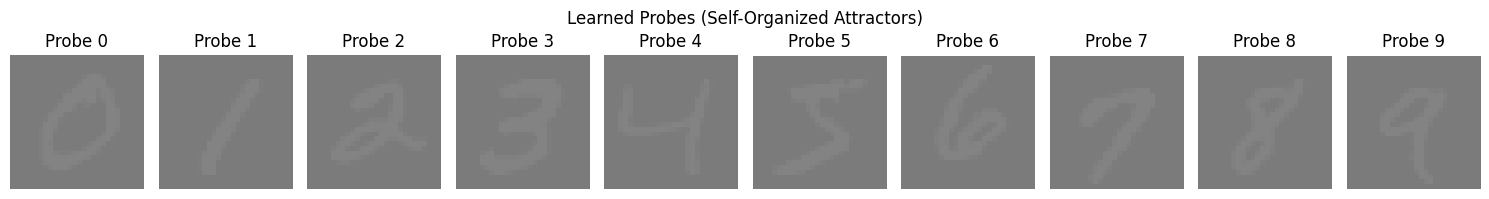

In [9]:
model = SamadhiModel(CONFIG)
# Calculate mean digits and load into probes
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
m_train_dataset_raw_for_probes = datasets.MNIST("./data", train=True, download=True, transform=transform)

# --- Probe Initialization Logic (Representative Sample per Label) ---
print("Initializing probes with Representative Sample per Label...")

# Find a representative image for each label
representative_images = [None] * CONFIG["n_probes"]
found_labels = [False] * CONFIG["n_probes"]

for img, label in m_train_dataset_raw_for_probes:
    if not found_labels[label]:
        representative_images[label] = img.view(-1)
        found_labels[label] = True

    if all(found_labels):
        break

# Stack and load into model
centroids = torch.stack(representative_images)
model.load_probes(centroids)
print("Probes initialized with Representative Sample per Label.")

# Visualize probes BEFORE training
visualize_probes(model)


In [10]:
trainable_params = (
    list(model.vitakka.adapter.parameters())
    + list(model.vicara.refiners.parameters())
    + list(model.decoder.parameters())
    + [model.probes]
)
optimizer = optim.Adam(trainable_params, lr=0.001)


# 2. Initialize Trainer
trainer = SupervisedSamadhiTrainer(model, optimizer)


# 3. Define noise injection function
def mnist_noise_injector(clean_data_flat):
    # Add Gaussian noise
    noise = torch.randn_like(clean_data_flat) * 0.7
    return clean_data_flat + noise


# 4. Data Preparation (Use Custom Dataset)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Train Dataset
m_train_dataset_raw = datasets.MNIST("./data", train=True, download=True, transform=transform)
m_train_dataset_pair = MNISTPairDataset(m_train_dataset_raw, mnist_noise_injector)
train_dataloader = torch.utils.data.DataLoader(m_train_dataset_pair, batch_size=64, shuffle=True)

# Test Dataset
m_test_dataset_raw = datasets.MNIST("./data", train=False, download=True, transform=transform)
m_test_dataset_pair = MNISTPairDataset(m_test_dataset_raw, mnist_noise_injector)
test_dataloader = torch.utils.data.DataLoader(m_test_dataset_pair, batch_size=64, shuffle=True)


# 5. Start Training! (Fit)
history = trainer.fit(train_dataloader, epochs=10)


Trainer initialized on device: mps

--- Start Supervised Training (10 epochs) ---
Device: mps
Params: Stability=0.01, Entropy=0.05, Balance=0.9
Epoch 1/10 | Batch 900 | Loss: 0.1798
Epoch 1 Finished. Avg Loss: 0.2193
Epoch 2/10 | Batch 900 | Loss: 0.1655
Epoch 2 Finished. Avg Loss: 0.1770
Epoch 3/10 | Batch 900 | Loss: 0.1728
Epoch 3 Finished. Avg Loss: 0.1619
Epoch 4/10 | Batch 900 | Loss: 0.1424
Epoch 4 Finished. Avg Loss: 0.1512
Epoch 5/10 | Batch 900 | Loss: 0.1387
Epoch 5 Finished. Avg Loss: 0.1434
Epoch 6/10 | Batch 900 | Loss: 0.1365
Epoch 6 Finished. Avg Loss: 0.1375
Epoch 7/10 | Batch 900 | Loss: 0.1312
Epoch 7 Finished. Avg Loss: 0.1323
Epoch 8/10 | Batch 900 | Loss: 0.1229
Epoch 8 Finished. Avg Loss: 0.1282
Epoch 9/10 | Batch 900 | Loss: 0.1145
Epoch 9 Finished. Avg Loss: 0.1246
Epoch 10/10 | Batch 900 | Loss: 0.1174
Epoch 10 Finished. Avg Loss: 0.1215



Calculating Probe Usage Statistics...
Probe Usage (over 256 samples):
  Probe 0: 25 (9.8%)
  Probe 1: 21 (8.2%)
  Probe 2: 28 (10.9%)
  Probe 3: 22 (8.6%)
  Probe 4: 18 (7.0%)
  Probe 5: 27 (10.5%)
  Probe 6: 34 (13.3%)
  Probe 7: 22 (8.6%)
  Probe 8: 22 (8.6%)
  Probe 9: 37 (14.5%)
  All probes are active!
Running inference...

ID  | Truth | Pred  | Conf   | Result
---------------------------------------------
0   | 7     | 4     | 0.88   | (Purified)
1   | 5     | 5     | 0.31   | (Purified)
2   | 6     | 6     | 0.99   | (Purified)
3   | 4     | 9     | 0.87   | (Purified)
4   | 4     | 9     | 0.94   | (Purified)
---------------------------------------------


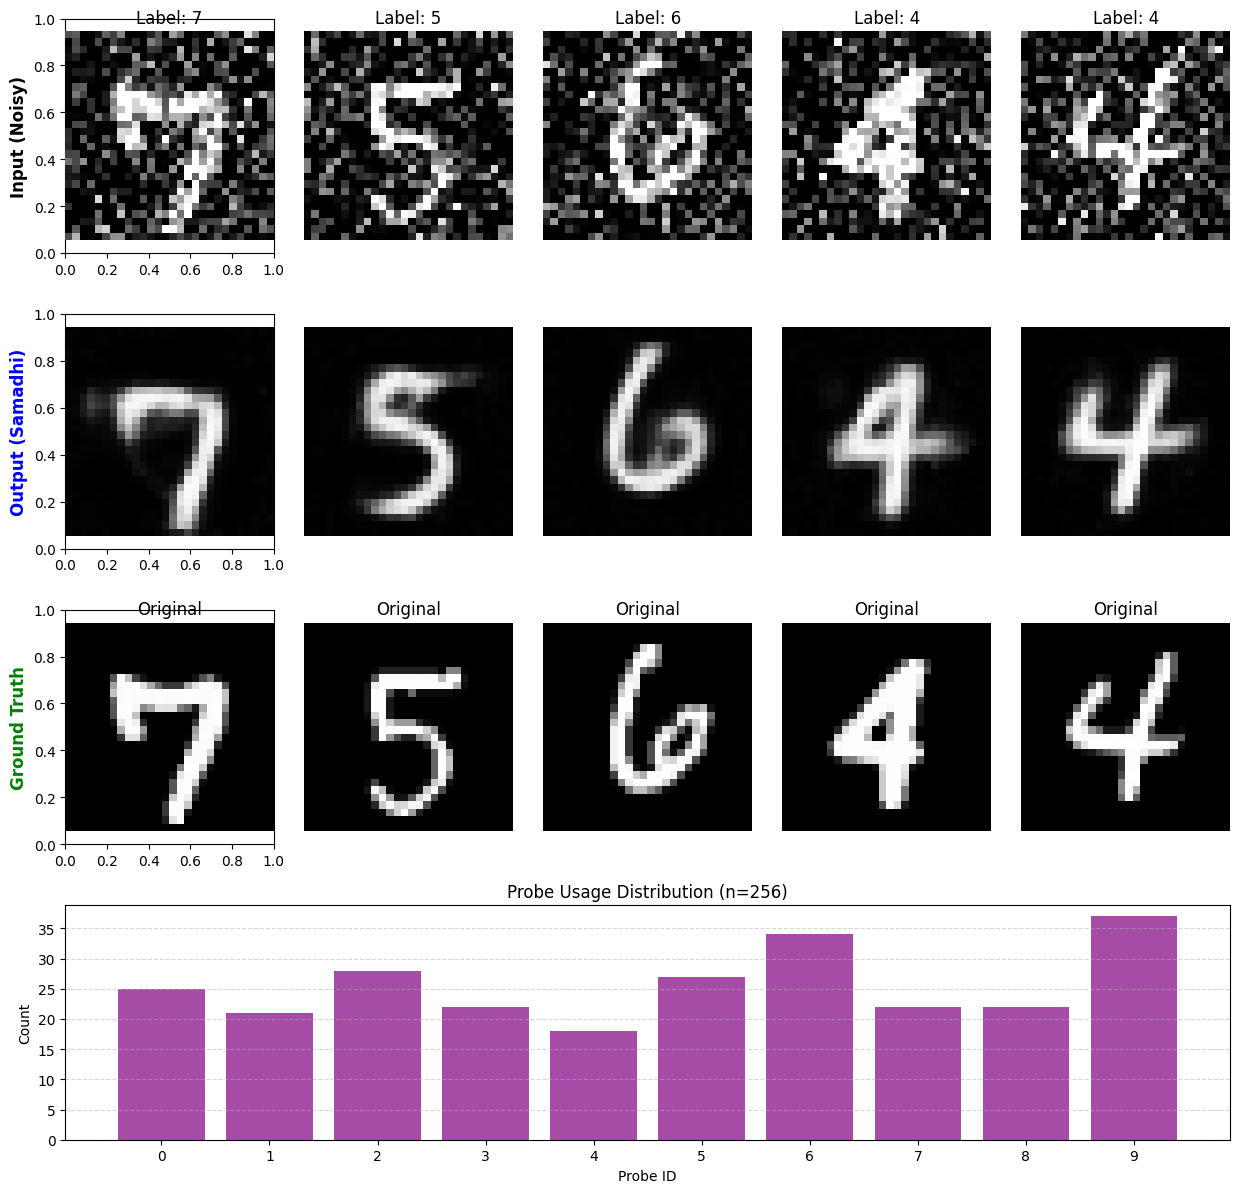


Visualizing Probes (Learned Concepts)...


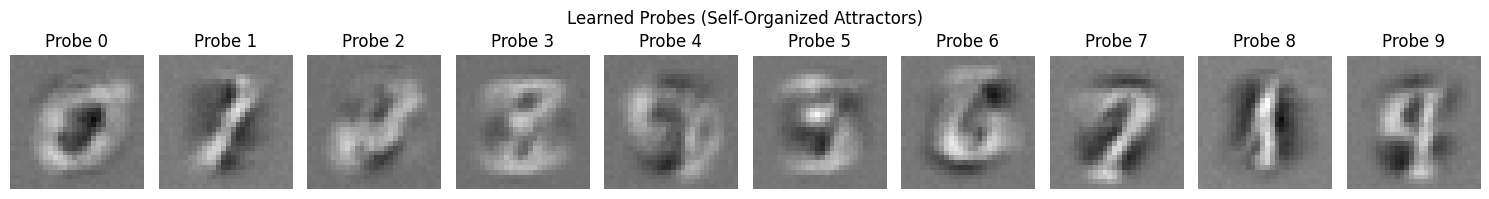

In [11]:
# --- Execution ---
visualize_inference(trainer, test_dataloader)
visualize_probes(model)
